In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets
import warnings

import time

np.set_printoptions(formatter={'float': lambda x : np.format_float_scientific(x, precision=7)})

lx = 1.0
ly = 1.0
lz = 2.0

bottom_bound = 7.0
top_bound    = -6.0
left_bound   = 5.0
right_bound  = -4.0
front_bound  = 3.0
back_bound   = -2.0

init_val = 5.0

In [2]:
def solve_liebmann(nx, ny, nz, *, eps):
    def initialize_grid(nx, ny, nz):
        x_step = lx / (nx - 2)
        y_step = ly / (ny - 2)
        z_step = lz / (nz - 2)
        grid = np.zeros((nz, ny, nx))

        grid[ :,  :,  0] = left_bound
        grid[ :,  :, -1] = right_bound
        grid[ :,  0,  :] = front_bound
        grid[ :, -1,  :] = back_bound
        grid[ 0,  :,  :] = bottom_bound
        grid[-1,  :,  :] = top_bound

        grid[1:-1, 1:-1, 1:-1] = init_val
        
        return grid

    def calc_grid_val(u_up, u_left, u_down, u_right, u_front, u_back, h_x, h_y, h_z):
        inv_hx2 = 1 / (h_x * h_x)
        inv_hy2 = 1 / (h_y * h_y)
        inv_hz2 = 1 / (h_z * h_z)
    
        new_val = (
            (u_right + u_left) * inv_hx2 +
            (u_up    + u_down) * inv_hy2 +
            (u_front + u_back) * inv_hz2
        ) / ( 2 * (inv_hx2 + inv_hy2 + inv_hz2) )
        
        return new_val
    
    x_step = lx / (nx - 2)
    y_step = ly / (ny - 2)
    z_step = lz / (nz - 2)
    old_grid = initialize_grid(nx, ny, nz)
    new_grid = initialize_grid(nx, ny, nz)
    
    # Force at least one iteration
    u_max_prev = np.max(np.abs(old_grid))
    u_max = u_max_prev + eps * 2

    while abs(u_max - u_max_prev) >= eps:
        t = old_grid
        old_grid = new_grid
        new_grid = t
        u_max_prev = u_max
        
        for z in range(1, nz - 1):
            for y in range(1, ny - 1):
                for x in range(1, nx - 1):
                    u_up    = old_grid[    z, y - 1,     x]
                    u_down  = old_grid[    z, y + 1,     x]
                    u_right = old_grid[    z,     y, x + 1]
                    u_left  = old_grid[    z,     y, x - 1]
                    u_back  = old_grid[z + 1,     y,     x]
                    u_front = old_grid[z - 1,     y,     x]
                    
                    val = 0.5 * ((old_grid[z, y, x + 1] + old_grid[z, y, x - 1]) / (x_step * x_step) +
                                 (old_grid[z, y + 1, x] + old_grid[z, y - 1, x]) / (y_step * y_step) +
                                 (old_grid[z + 1, y, x] + old_grid[z - 1, y, x]) / (z_step * z_step)) / \
                            (1.0 / (x_step * x_step) +  1.0 / (y_step * y_step) +  1.0 / (z_step * z_step))
                    new_grid[z, y, x] = val


        u_max = np.max( np.abs(new_grid[1:-1, 1:-1, 1:-1]) )

    return new_grid

In [3]:
block_x,  block_y,  block_z  = 10, 10, 10
thread_x, thread_y, thread_z = 1, 1, 1
x_count, y_count, z_count = block_x * thread_x + 2, block_y * thread_y + 2, block_z * thread_z + 2
grid = solve_liebmann(x_count, y_count, z_count, eps=1e-7)

In [4]:
x_step = lx / (x_count - 2)
y_step = ly / (y_count - 2)
z_step = lz / (z_count - 2)

In [5]:
x_list = np.zeros(((x_count) * (y_count) * (z_count), ))
y_list = x_list.copy()
z_list = x_list.copy()
c_list = x_list.copy()

elem_i = 0
for z in range(0, z_count):
    for y in range(0, y_count):
        for x in range(0, x_count):
            x_list[elem_i] = x * x_step
            y_list[elem_i] = y * y_step
            z_list[elem_i] = z * z_step
            c_list[elem_i] = grid[z, y, x]
            elem_i += 1

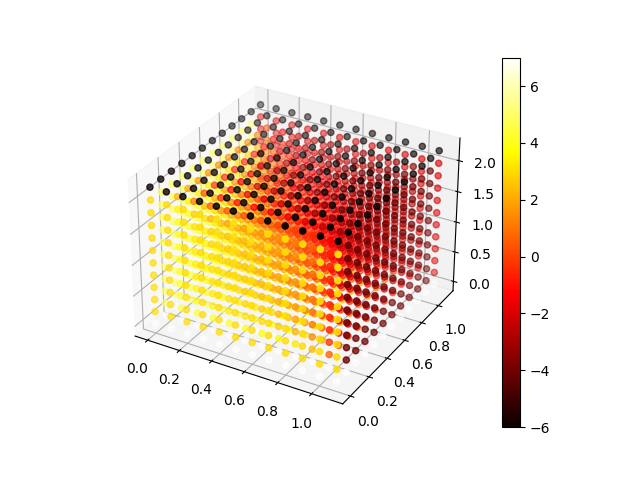

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

img = ax.scatter(x_list, y_list, z_list, c=c_list, cmap=plt.hot())
fig.colorbar(img)
plt.show()


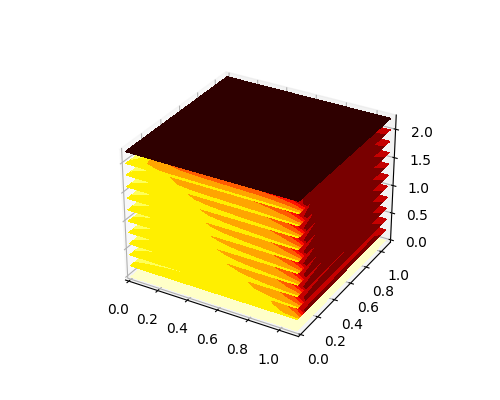

In [7]:
import matplotlib.pyplot as plt
import numpy as np

Nx, Ny = x_count, y_count
X, Y = np.meshgrid(np.arange(Nx) * x_step, np.arange(Ny) * y_step)

data = grid

kw = {
    'vmin': data.min(),
    'vmax': data.max(),
    'levels': np.linspace(data.min(), data.max(), 10),
}

# Create a figure with 3D ax
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, projection='3d')

for z in range(z_count):
    _ = ax.contourf(
        X, Y, grid[z, :, :],
        zdir='z', offset=z * z_step, **kw
    )
    


# Set limits of the plot from coord limits
xmin, xmax = X.min(), X.max()
ymin, ymax = Y.min(), Y.max()
zmin, zmax = 0, (z_count - 1) * z_step
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])

# Show Figure
plt.show()